Dataset1: https://www.kaggle.com/pranavraikokte/covid19-image-dataset


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Wed Jun 14 02:51:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 7.3 MB/s eta 0:00:00


# Import Libraries & Modules

In [5]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from torchmetrics import Accuracy
from tqdm import tqdm
from rich import print

torch.manual_seed(0)

# Load Dataset and read images

## calculate mean & std for normzlize

In [ ]:
train_data = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Datasets/Covid19-dataset/train',
                                              transform=transforms.Compose([
                                                        transforms.Resize(size = (224, 224)),
                                                        transforms.ToTensor()]))

train_loader_all = DataLoader(train_data, batch_size=len(train_data), shuffle=False)

def mean_std(loader):
    images, lebels = next(iter(loader))

    # shape of images = [b,c,w,h]
    mean_imgs, std_imgs = images.mean([0,2,3]), images.std([0,2,3])
    return mean_imgs, std_imgs

mean_imgs, std_imgs = mean_std(train_loader_all)
print(f'mean images={mean_imgs}\n std images={std_imgs}')

mean images=tensor([0.4954, 0.4954, 0.4955])
 std images=tensor([0.2801, 0.2801, 0.2801])

## transform

In [6]:
train_transform = transforms.Compose([transforms.Resize(size = (224, 224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.4954, 0.4954, 0.4955],
                                                            std=[0.2801, 0.2801, 0.2801])])

test_transform = transforms.Compose([transforms.Resize(size = (224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.4954, 0.4954, 0.4955],
                                                          std=[0.2801, 0.2801, 0.2801])])

## Load dataset

In [7]:
train_data = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Datasets/Covid19-dataset/train',
                                             transform=train_transform)

test_data = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Datasets/Covid19-dataset/test',
                                            transform=test_transform)

## Name classes and Number of data within each class

In [8]:
print(train_data.class_to_idx)
print(test_data.class_to_idx)

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}

In [ ]:
def count_class_img(dataset):
    count_class = {'Covid': 0,
                   'Normal': 0,
                   'Viral': 0}

    for i in dataset.imgs:
        if i[1] == 0:
            count_class['Covid'] += 1
        elif i[1] == 1:
            count_class['Normal'] += 1
        else:
            count_class['Viral'] += 1

    # print(f'{count_class} => sum class={sum(count_class.values())}')
    return count_class

In [ ]:
count_class_img(train_data), count_class_img(test_data)

({'Covid': 111, 'Normal': 70, 'Viral': 70},
 {'Covid': 26, 'Normal': 20, 'Viral': 20})

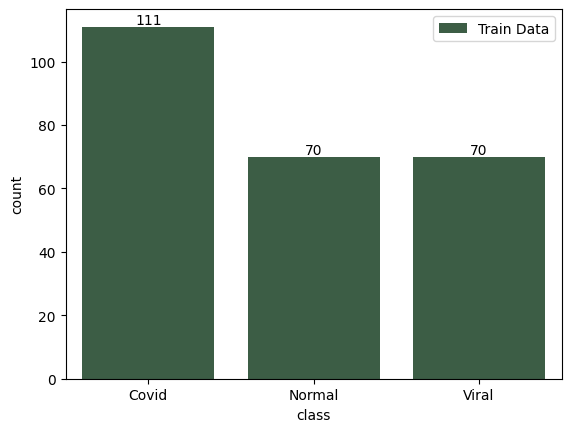

In [ ]:
df = count_class_img(train_data)
df = pd.DataFrame({'class': df.keys(), 'count': df.values()})

ax = sns.barplot(x='class', y='count', data=df, label='Train Data', color='#376242')
ax.bar_label(ax.containers[0], fmt='%.0f')
plt.legend()

## DataLoader

In [9]:
batch_size = 6

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=11, shuffle=True)

print('Number of training batches', len(train_loader))
print('Number of test batches', len(test_loader))

Number of training batches 42

Number of test batches 6

# Show Images

In [10]:
class_names = train_data.classes

def show_images(images, labels, preds):
    plt.figure(figsize=(16, 9))
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i + 1, xticks = [], yticks = [])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image*std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color = col)
    plt.tight_layout()
    plt.show()

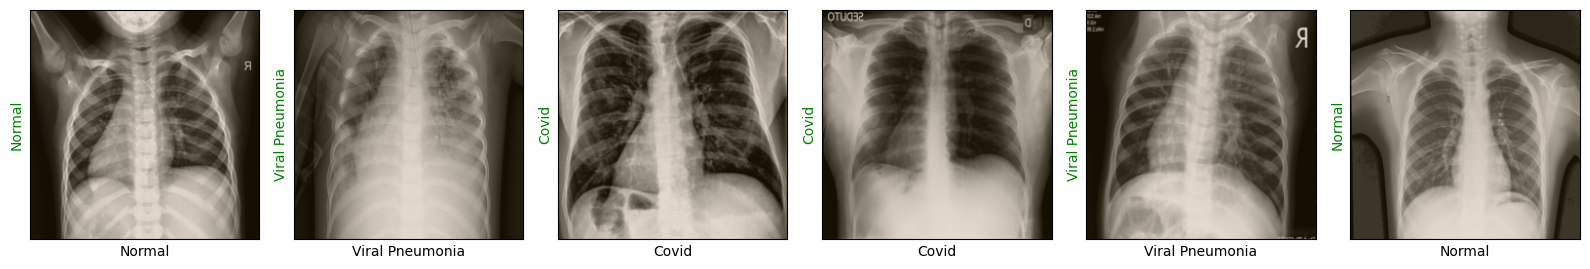

In [ ]:
images, labels = next(iter(train_loader))
show_images(images, labels, labels)

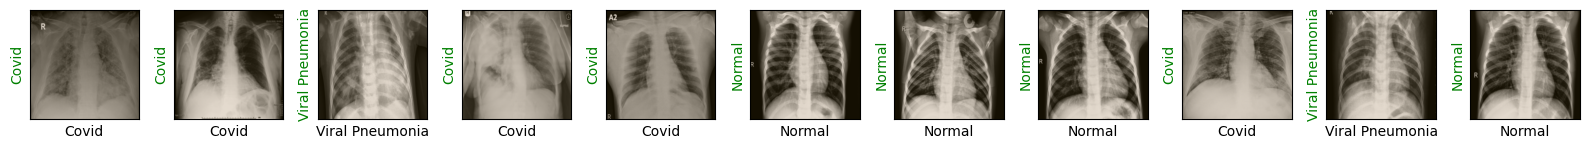

In [ ]:
images, labels = next(iter(test_loader))
show_images(images, labels, labels)

# Create model Resnet(18layer)

In [29]:
model = torchvision.models.resnet18(pretrained = True)

print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer3): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): 

In [30]:
in_features = 512
out_features = 3

model.fc = nn.Linear(in_features=in_features, out_features=out_features)

# Device

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Loss function & Optimizer

In [32]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)

# Utils

In [33]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Train Model

In [34]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
    model.train()
    loss_train = AverageMeter()
    acc_train = Accuracy(task='multiclass', num_classes=3).to(device)

    with tqdm(train_loader, unit='batch') as tepoch:
        for inputs, targets in tepoch:
            if epoch is not None:
                tepoch.set_description(f'Epoch {epoch}')
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train.update(loss.item())
            acc_train(outputs, targets.int())

            tepoch.set_postfix(loss=loss_train.avg,
                                accuracy=100.*acc_train.compute().item())
    return model, loss_train.avg, acc_train.compute().item()

# Evaluation Model

In [35]:
def evaluate(model, eval_loader, loss_fn):
    model.eval()

    with torch.no_grad():
        loss_eval = AverageMeter()
        acc_eval = Accuracy(task='multiclass', num_classes=3).to(device)

        for i, (inputs, targets) in enumerate(eval_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            loss_eval.update(loss.item())
            acc_eval(outputs, targets.int())

    _, preds = torch.max(outputs, 1)
    show_images(inputs.cpu(), targets.cpu(), preds.cpu())

    return loss_eval.avg, acc_eval.compute()

Epoch 0: 100%|██████████| 42/42 [00:19<00:00,  2.10batch/s, accuracy=80.1, loss=0.568]


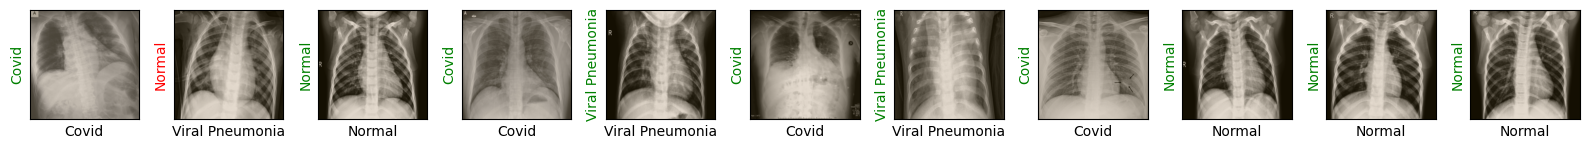

ُTest: Loss=0.25, Accuracy=9.5e+01

Epoch 1: 100%|██████████| 42/42 [00:18<00:00,  2.24batch/s, accuracy=90.4, loss=0.264]


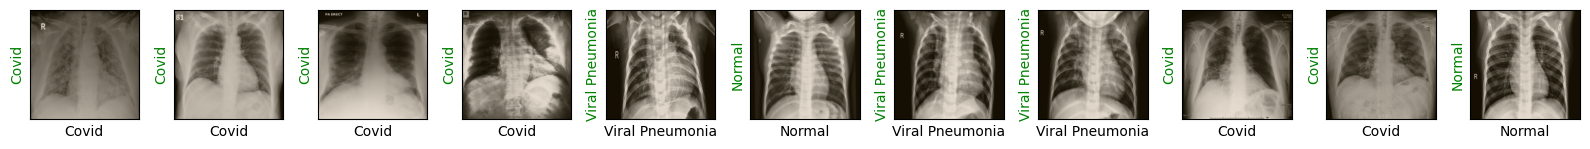

ُTest: Loss=0.12, Accuracy=9.8e+01

Epoch 2: 100%|██████████| 42/42 [00:19<00:00,  2.10batch/s, accuracy=94.4, loss=0.195]


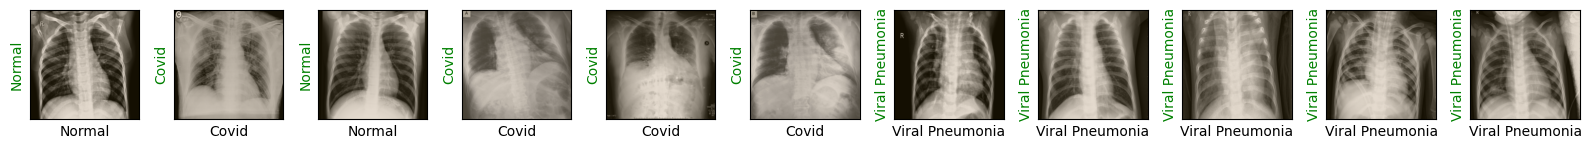

ُTest: Loss=0.093, Accuracy=9.8e+01

In [36]:
num_epochs = 3

for epoch in range(num_epochs):
    model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)

    loss_test, acc_test = evaluate(model,
                                   test_loader,
                                   loss_fn)

    print(f'ُTest: Loss={loss_test:.2}, Accuracy={100 * acc_test:.2}\n')